%
\section{Classification Dataset: Pittsburgh bridges dataset (\href{https://archive.ics.uci.edu/ml/datasets/Pittsburgh+Bridges}{link to dataset})}

The Pittsburgh dataset is used for classification, it is a prediction on the type of the bridge.

It consists of 108 samples, 12 attributes and the target variable, which is the type of the bridge, and this label is a nominal value among "simple-t" (simple truss), "cont-t" (continuous truss), "cantilev" (cantilever truss), "arch", "suspen" (suspension) or "wood". This dataset is quite small with a medium dimension. The 12 attributes are the following: 

1.IDENTIF: identifier of the example. It is not relevant, we will drop it

2.RIVER:  the crossed river ("A" for Allegheny, "O" for Ihoa, "M" for Monongahela or "Y" for Youghigheny)

3.LOCATION: bridge location (1 to 52, nominal value)

4.ERECTED: period in time when the bridge was built (nominal value among "crafts", "emerging", "mature", "modern")

5.PURPOSE: purpose of the construction (nominal value among "walk", "aqueduct", "rr", "highway")  

6.LENGTH: total length of the crossing (nominal value among "short", "medium", long")

7.LANES: number of lanes (nominal value among 1, 2, 4, 6)

8.CLEAR-G:  a  vertical  navigation clearance requirement was enforced in the design ("G") or not ("N")

9.T-OR-D:  specifies  the  vertical  location  of  the roadway on the bridge: within the structure ("through") or on top of it ("deck")

10.MATERIAL: material that the bridge was built: nominal value among "iron","wood","steel"

11.SPAN: length of the main span of the bridge (nominal value among "short", "medium", long")

12.REL-L: relative length of the main span of the bridge to the total crossing length (nominal value among "S", "S-F", "F")

We can see that there are some missing values, and we have the repartition of missing values among samples with the following table {insert table}. We can notice that the feature "LENGTH" is the most incomplete one, with 25% missing values, and "LANES" and "SPAN" have 15% missing values. The other features having less than 6% missing values. We can also notice that three labels are missing, so we have to drop it.

This trainset is imbalanced, with a bit less than the half of the samples which are labellized as simple truss... we can already imagine that our results will not be very accurate according to the small amount of samples and this very imbalanced dataset (we only have around 10 samples per label in most of cases).

The threshold for the minimum number of known values to conserve for a row will be a tuning parameter for the algorithms.
We also tried to impute them with a KNN imputer.

During preprocessing, we transform split each feature with a nominal value to as many features as the number of distinct values in order to have only binary values. So we have now a much bigger dimension, #########.

In [134]:
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

attributes = ["river", "location", "erected", "purpose", "length", "lanes", "clear-g", "t-or-d", "material", "span", "rel-l"]
training = pd.read_csv("./bridges v2.csv", names= attributes + ["type"])
training_init = training.copy()

# Preprocessing and analysis of dataset

In [135]:
# replaces "?" by NaN values and drops the samples of the training set with a bad value for type or less than 'thres' known values

def clean_rows(data, thres=1) :
    d = data.applymap(lambda x : np.nan if x == "?" else x)
    d = d[(d['type'] != "NIL") & (d['type'].notna())]
    return d.dropna(axis=0, thresh=thres, subset=None, inplace=False)

# imputate the missing values following two possible methods : if imputation=1, we use the KNeighbors imputation algorithm 
# and if 0, we just replace by random values

def imputate(data, imputation) :
    # imputation
    imp = KNNImputer(n_neighbors=1)
    
    # dictionnary with columns names as keys and a list of all the distinct values as value
    dico = {}
    for col in data :
        dico[col] = list(data[col].dropna().unique())
    
    if (imputation) :
        # we need to transform our entries in numerical values
        d = data.copy()
        for col in data :
            d[col] = data[col].map(lambda x : dico[col].index(x) if isinstance(x, str) else x)
        try:
            t = d.drop('type', axis=1)
        except:
            # it's the test set and we already have trained our imputation function
            array = imp.transform(d)
            d = pd.DataFrame(array, columns = d.columns)
        else:
            # we fit the multivariate feature imputation
            imp.fit(t)
            # we use it on training dataset
            array = imp.transform(t)
            t = pd.DataFrame(array, columns = t.columns)
            t.index = d.index
            t['type'] = d['type']
            d = t
        # we process the reversed transformation
        for col in data :
            d[col] = d[col].map(lambda x : dico[col][round(x)])
    else :
        #we transform unknown values in other values from the list of distinct values randomly
        d = data.copy()
        for col in data :
            d[col] = d[col].fillna(random.choice(dico[col]))
    return d

def split_nominal(data) :
    D = []
    d = data.drop('type', axis=1)
    for a in attributes :
        D.append(pd.get_dummies(d[a], prefix = a + "_"))
    D.append(data['type'])
    return pd.concat(D, axis=1)
    
# returns a table with the number of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d

# plots the final result of classification

def plot_result_classes(data, name) :
    countplt, ax = plt.subplots(figsize = (5,5))
    ax = sns.countplot(data=data, x='type')
    ax.set_title("Number of samples per class")
    ax.set_xticklabels(data["type"].unique(), rotation=45)
    plt.savefig("./" + name + ".pdf")

In [136]:
training = clean_rows(training)
number_of_samples_per_number_of_missing_values(training)

0    70
1    17
2    13
3     2
4     3
Name: missing values in row, dtype: int64

We can see that if we have a threshold at 12 known values for the preprocessing, we will lose a third of the information. On the contrary, with a threshold at 10, we keep barely the whole information.

In [137]:
training.describe()

,river,location,erected,purpose,length,lanes,clear-g,t-or-d,material,span,rel-l,type
count,105,104,105,105,81,92,103,102,105,92,100,105
unique,4,54,4,4,3,4,2,2,3,3,3,6
top,A,27,MATURE,HIGHWAY,MEDIUM,2,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
freq,47,4,53,69,48,61,77,87,78,53,55,44


In [138]:
training = imputate(training, False)
training.describe()

,river,location,erected,purpose,length,lanes,clear-g,t-or-d,material,span,rel-l,type
count,105,105,105,105,105,105,105,105,105,105,105,105
unique,4,54,4,4,3,4,2,2,3,3,3,6
top,A,27,MATURE,HIGHWAY,MEDIUM,2,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
freq,47,4,53,69,48,61,79,87,78,66,55,44


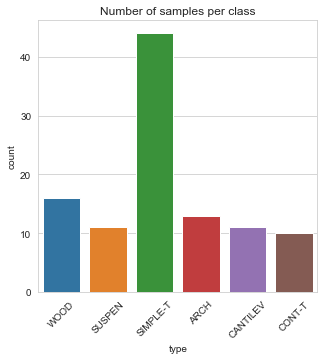

In [139]:
plot_result_classes(training, "classification_trainset")

In [140]:
training = split_nominal(training)
training.describe()

,river__A,river__M,river__O,river__Y,location__1,location__10,location__11,location__12,location__13,location__14,...,t-or-d__THROUGH,material__IRON,material__STEEL,material__WOOD,span__LONG,span__MEDIUM,span__SHORT,rel-l__F,rel-l__S,rel-l__S-F
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.447619,0.390476,0.133333,0.028571,0.028571,0.019048,0.019048,0.009524,0.009524,0.019048,...,0.828571,0.104762,0.742857,0.152381,0.285714,0.628571,0.085714,0.523810,0.285714,0.190476
std,0.499634,0.490197,0.341565,0.167398,0.167398,0.137348,0.137348,0.097590,0.097590,0.137348,...,0.378691,0.307715,0.439155,0.361113,0.453921,0.485504,0.281284,0.501828,0.453921,0.394560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training models : perceptron, random forest and naive Bayes

We decide to take cv=3 (number of folds) for the cross validation because our number of samples is very small.

In [141]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as preprocess

le = preprocess.LabelEncoder()
target_init = np.array(training_init)[:,-1]
le.fit(target_init)

# preprocessing with as parameters : 
#    thres : threshold for the number of minimum known values
#    imp : if true, uses the mmultivariate imputation, if not, fills missing values with random binary values
# outputs the training set, the target for the training, the test set and the target for the test set

def preprocessing(thres, imp) :
    training = clean_rows(training_init, thres)
    training = imputate(training, imp)
    training = split_nominal(training)
    train_set, test_set = train_test_split(training, test_size=0.2, random_state=42)
    train = np.array(train_set)[:,:-1]
    target = np.array(train_set)[:,-1]
    train_target = le.transform(target)
    test = np.array(test_set)[:,:-1]
    t_target = np.array(test_set)[:,-1]
    test_target = le.transform(t_target)
    
    return train, train_target, test, test_target

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
sns.set_style('whitegrid')

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a perceptron
# with the inputs as parameters

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=3)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a random forest
# with the inputs as parameters

def create_rnd_forest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=3)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a naive Bayes
# with the inputs as parameters

def create_nb(train_data, target, grid=[], **kwargs) :
    if grid != []:
        clf = GridSearchCV(MultinomialNB(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=3)
    else :
        clf =MultinomialNB(**kwargs)
    clf.fit(train_data , target)
    return clf

def most_frequent(List):
    counter = 0
    num = List[0]
      
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
  
    return num
    
# evaluates the algorithm by printing the relevant metrics and the confusion matrix for both train and test sets
# outputs the metrics as a dictionary
    
def evaluate_algo(algo, test_data, test_target, train_data, train_target):
    
    print(algo)
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)
    
    # outputs
    metrics_train = {"accuracy": 0, "balanced_accuracy": 0, "f1_macro": 0, "precision_macro": 0, "recall_macro": 0}
    metrics_test = {"accuracy": 0, "balanced_accuracy": 0, "f1_macro": 0, "precision_macro": 0, "recall_macro": 0}
    
    metrics_test["accuracy"] = accuracy_score(test_target, pred_test)
    metrics_test["balanced_accuracy"] = balanced_accuracy_score(test_target, pred_test)
    metrics_test["f1_macro"] = f1_score(test_target, pred_test, average="macro")
    metrics_test["precision_macro"] = precision_score(test_target, pred_test, average="macro")
    metrics_test["recall_macro"] = recall_score(test_target, pred_test, average="macro")
    
    # report of metrics
    for score in metrics_train.keys():
        sc_train = cross_val_score(algo, train_data, train_target, cv=3, scoring=score).mean()
        print("cross validation " + score + " train : "+ str(sc_train))
        metrics_train[score] = sc_train
    
        print(score + " test : "+ str(metrics_test[score]))
    
    # plot of the confusion matrix
    cmat = confusion_matrix(test_target, pred_test)
    cmat_train = confusion_matrix(train_target, pred_train)
    print("\n")
    print("Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T")
    print("test : ")
    print(cmat) 
    print("train : ")
    print(cmat_train) 
    
    return metrics_test, metrics_train

# Perceptron

Test of different preprocessing methods with the optimal parameters found with grid search. We launch it 5 times to prevent a too large variation because of the random of the preprocessing. We have a range for thresholds of known values between 5 and 10 because we want to avoid having too less known values per sample (too large part for random values) or avoid the deletion of too much data because of the unknown values.

5
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
6
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
7
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Fitting 3 folds for each of 512 candidates, totalling 1536 fits
8
Fitting 3 folds for each of 512 

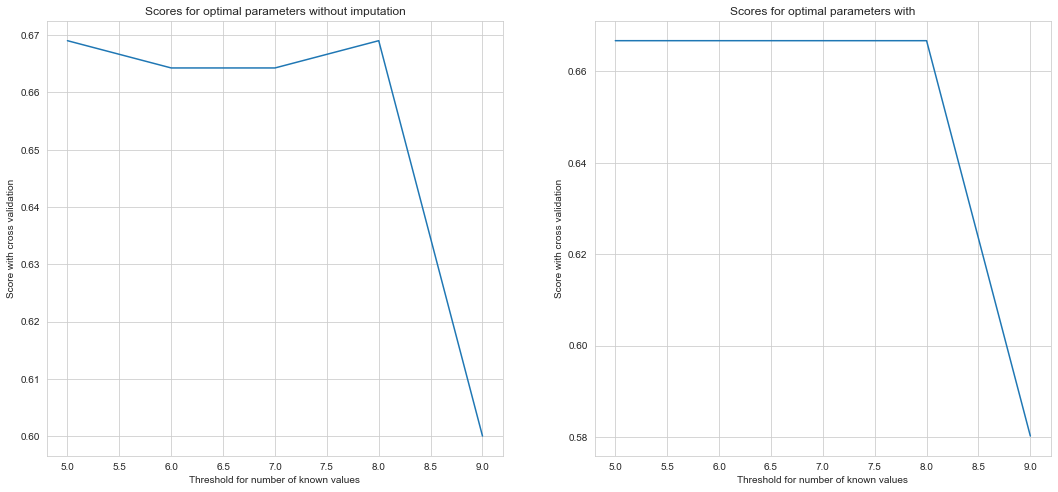

In [151]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {'eta0': [0.1,0.2,0.3,0.4],  
              'early_stopping': [True, False],
              'max_iter':[10,20,30,100],
              'tol':[1e-4,1e-3,1e-2,1e-1],
              'penalty':["l2","l1","elasticnet","None"]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [False, True] :
    thresholds = np.arange(5,10)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        PPN = []
        PREPROS = []
        n = 5
        
        if (imputation) :
            n=1 
            
        for i in range(n) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            PPN.append( create_perceptron(train, train_target, grid = param_grid) )
            score += PPN[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,PPN,PREPROS))
        scores.append(score/n)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_ppn" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We can see that the two imputation methods give quite the same results, so we choose the 1NN imputer because it is reproductible and we have always the same trainset so the results are more reliable. The optimal threshold is 10. 

Now with this preprocessing method, we evaluate the perceptron method optimized by grid search. Because of the random values, the optimize values can change from one run to another, that is why we repeated it 5 times and for the scores we always take the mean of the ten values for the 5 preprocessing configurations.

In [152]:
prepro_text = ""
best_ppn = None
datasets = []
score = 0
for (text, PPN, PREPROS) in L :
    new_score = 0
    for i in range(len(PREPROS)) :
        prepro = PREPROS[i]
        ppn = PPN[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += ppn.best_score_
    new_score /= len(PREPROS)
    if new_score > score :
        score = new_score
        prepro_text = text
        best_ppn = PPN
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_ppn)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_ppn = best_ppn[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
ppn_grid = create_perceptron(train, train_target, **best_ppn.best_params_)
metrics_ppn = evaluate_algo(ppn_grid, test, test_target, train, train_target)

imputation: False, threshold = 5
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 10, 'penalty': 'None', 'tol': 0.0001}
{'early_stopping': True, 'eta0': 0.3, 'max_iter': 10, 'penalty': 'l1', 'tol': 0.0001}
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 20, 'penalty': 'l1', 'tol': 0.0001}
{'early_stopping': False, 'eta0': 0.4, 'max_iter': 10, 'penalty': 'None', 'tol': 0.1}
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 20, 'penalty': 'l2', 'tol': 0.01}


Perceptron(eta0=0.3, max_iter=10, penalty='None', tol=0.0001)
cross validation accuracy train : 0.6785714285714285
accuracy test : 0.8095238095238095
cross validation balanced_accuracy train : 0.595959595959596
balanced_accuracy test : 0.8266666666666665
cross validation f1_macro train : 0.5715568382235049
f1_macro test : 0.6314814814814814
cross validation precision_macro train : 0.5925546675546675
precision_macro test : 0.6388888888888888
cross validation recall_macro train : 0.595959595959596
recall_macro test : 0.688888888

We had a huge overfitting with grid search when we were taking 10 as threshold, so we decided to change it and have a more data. Hence, the test score is much higher. However it would be a great idea to launch it only with imputation to avoid a random perfect configuration: if we do it, we have the following results:

imputation: True, threshold = 5
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 10, 'penalty': 'elasticnet', 'tol': 0.1}


Perceptron(eta0=0.1, max_iter=10, penalty='elasticnet', tol=0.1)

cross validation accuracy train : 0.6666666666666666

accuracy test : 0.8571428571428571

cross validation balanced_accuracy train : 0.5589225589225589

balanced_accuracy test : 0.7133333333333333

cross validation f1_macro train : 0.5159465481304563

f1_macro test : 0.5864661654135338

cross validation precision_macro train : 0.5326861047449283

precision_macro test : 0.5833333333333334

cross validation recall_macro train : 0.5589225589225589

recall_macro test : 0.5944444444444444


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T

test : 
[[2 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 2 0 0 0]
 [1 0 0 9 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 5]]
 
train : 
[[10  0  0  0  0  0]
 [ 3  3  0  4  0  0]
 [ 0  0  8  0  0  0]
 [ 1  0  0 33  0  0]
 [ 0  0  0  2  9  0]
 [ 0  0  0  0  0 11]]

We can also notice that there are 3 best parameters among the 5 algorithms so that is not very stable. Finally, the problem is the imbalanced data: it works very well for the 2 features with a lot of samples, but not for the others.

We try to optimize it manually now. 

To optimize manually, we use a validation set to compare and be aware if we are overfitting too much. We do not create a third dataset to do so because we do not have enough data, but we try to optimize the trainset accuracy on first instance in order to introduce a too big bias. 

First we optimize the threshold of the preprocessing (we consider directly the 1NN imputation because it permit to have always the same training set and the accuracy is barely the same).

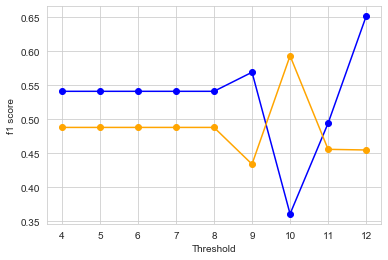

In [153]:
vals = np.arange(4,13)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(x, True)
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=20,tol=0.001, early_stopping=False, penalty=None)
    score = f1_score(test_target, ppn.predict(test), average="macro")
    score_cv = cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_ppn.pdf")

Best seems to be 6 as threshold, because with less than 6 as threshold the imputation does nothing more (no sample has less than 7 known values) and when we increase the threshold the f1 should overfit (on the trainset or on the testset) because we have too less data.

Now we optimize the maximum number of iterations

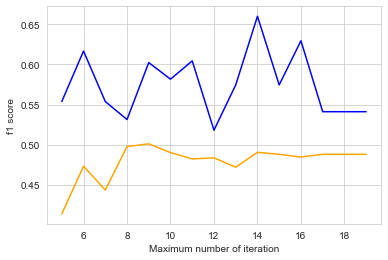

In [154]:
prepro_ppn = preprocessing(6, True)

# maximum iterations
vals      = np.arange(5,20)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = prepro_ppn
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=x,tol=0.001, early_stopping=False, penalty=None)
    score = f1_score(test_target, ppn.predict(test), average="macro")
    score_cv = cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Maximum number of iteration")
plt.ylabel("f1 score")
plt.savefig("./max_iter_ppn.pdf")

We choose 18 because the accuracy starts to be stable.

Now we choose the penalty parameter

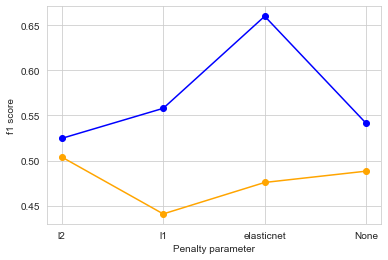

In [104]:
vals = ["l2","l1","elasticnet","None"]
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = prepro_ppn
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18, tol=0.001, early_stopping=False, penalty=x)
    score = f1_score(test_target, ppn.predict(test), average="macro")
    score_cv = cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Penalty parameter")
plt.ylabel("f1 score")
plt.savefig("./penalty_ppn.pdf")

l2 has no overfitting and is the best accuracy

Now we optimize the stopping criterion

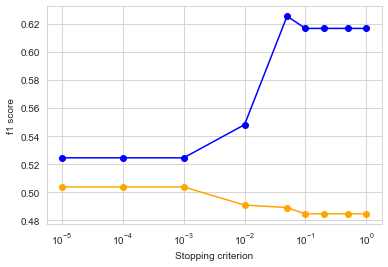

In [105]:
vals      = np.array([1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.2,0.5,1])
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = prepro_ppn
        ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18,tol=x, early_stopping=False, penalty="l2")
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")
plt.xlabel("Stopping criterion")
plt.ylabel("f1 score")
plt.savefig("./tol_ppn.pdf")

0.001 seems to be the best stopping criterion: it is the best f1 score for the trainset.

Now we optimize the learning rate

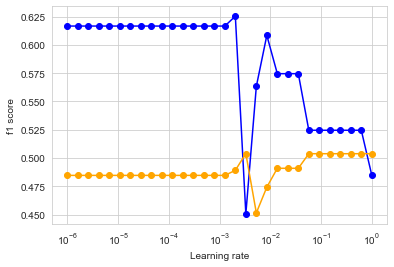

In [106]:
vals      = np.logspace(-6,0,num=30)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = prepro_ppn
    ppn = create_perceptron(train, train_target, eta0=x, max_iter=18,tol=0.001, early_stopping=False, penalty="l2")
    score = f1_score(test_target, ppn.predict(test), average="macro")
    score_cv = cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")
plt.xlabel("Learning rate")
plt.ylabel("f1 score")
plt.savefig("./learning_rate_ppn.pdf")

A learning rate of 0.05 is great for both datasets because it is stable and an optimum

Finally we choose if we want an early stopping

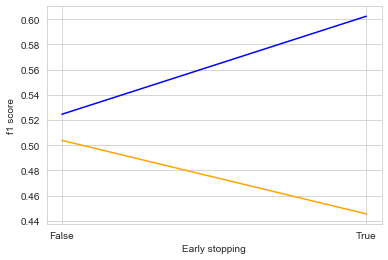

In [107]:
# early stopping
bools     = [False,True]
vals      = ["False","True"]
scores    = []
scores_cv = []
for x in bools :
    train, train_target, test, test_target = prepro_ppn
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18,tol=0.001, early_stopping=x, penalty="l2")
    score = f1_score(test_target, ppn.predict(test), average="macro")
    score_cv = cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Early stopping")
plt.ylabel("f1 score")
plt.savefig("./early_stopping_ppn.pdf")

No early stopping is better for both datasets.

Now we create the perceptron that we got manually and we evaluate it :

In [108]:
train, train_target, test, test_target = prepro_ppn
best_ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18,tol=0.001, early_stopping=False, penalty="l2")
metrics_ppn = evaluate_algo(best_ppn, test, test_target, train, train_target)

Perceptron(eta0=0.1, max_iter=18, penalty='l2')
cross validation accuracy train : 0.6190476190476191
accuracy test : 0.8095238095238095
cross validation balanced_accuracy train : 0.5454545454545454
balanced_accuracy test : 0.6466666666666667
cross validation f1_macro train : 0.5038303260525483
f1_macro test : 0.524561403508772
cross validation precision_macro train : 0.5646825396825397
precision_macro test : 0.5277777777777778
cross validation recall_macro train : 0.5454545454545454
recall_macro test : 0.5388888888888889


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T
test : 
[[1 0 1 0 1 0]
 [0 0 0 0 1 0]
 [0 0 2 0 0 0]
 [1 0 0 9 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 5]]
train : 
[[10  0  0  0  0  0]
 [ 0  9  1  0  0  0]
 [ 0  0  7  1  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0 11]]


So finally we have an underfitting for the accuracy compared to this test set when we do it manually, but we can see with the confusion matrix that in the train set we fit actually very well but when we do the cross validation it is not really the case, we can imagine that it is due to the small amount of data.

# Random forest

Test of different preprocessing methods with the optimal parameters found with grid search

5
Fitting 3 folds for each of 60 candidates, totalling 180 fits
6
Fitting 3 folds for each of 60 candidates, totalling 180 fits
7
Fitting 3 folds for each of 60 candidates, totalling 180 fits
8
Fitting 3 folds for each of 60 candidates, totalling 180 fits
9
Fitting 3 folds for each of 60 candidates, totalling 180 fits


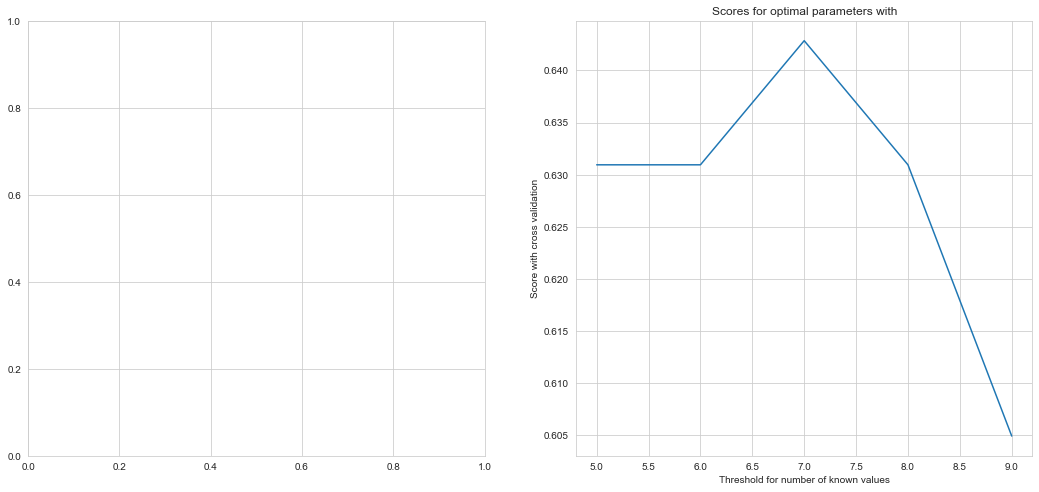

In [155]:
param_grid = {'criterion': ["gini", "entropy"],
              'n_estimators': [100],
              'min_samples_leaf': [0.01, 1, 2, 3, 4, 5],
              'ccp_alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
              #'min_samples_split': [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
             }  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True] :
    thresholds = np.arange(5,10)
    scores = []
    training = training_init.copy()
    for thres in thresholds :
        print(thres)
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        RNF = []
        PREPROS = []
        n = 5
        
        if (imputation) :
            n=1 
            
        for i in range(n) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            RNF.append( create_rnd_forest(train, train_target, grid = param_grid) )
            score += RNF[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,RNF,PREPROS))
        scores.append(score/n)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_rdf" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We ran other test and the relevant imputation is the random imputation. Here we can see that the optimal threshold is 7.

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [156]:
prepro_text = ""
best_rdf = None
datasets = []
score = 0
for (text, RDF, PREPROS) in L :
    new_score = 0
    for i in range(len(PREPROS)) :
        prepro = PREPROS[i]
        rdf = RDF[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += rdf.best_score_
    new_score /= len(PREPROS)
    if new_score > score :
        score = new_score
        prepro_text = text
        best_rdf = RDF
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_rdf)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_rdf = best_rdf[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
rdf_grid = create_rnd_forest(train, train_target, **best_rdf.best_params_)
metrics_rdf = evaluate_algo(rdf_grid, test, test_target, train, train_target)

imputation: True, threshold = 7
{'ccp_alpha': 0.0001, 'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100}


RandomForestClassifier(ccp_alpha=0.0001)
cross validation accuracy train : 0.6071428571428571
accuracy test : 0.8571428571428571
cross validation balanced_accuracy train : 0.4667508417508417
balanced_accuracy test : 0.7133333333333333
cross validation f1_macro train : 0.44383597883597886
f1_macro test : 0.6023391812865496
cross validation precision_macro train : 0.5226268285091814
precision_macro test : 0.611111111111111
cross validation recall_macro train : 0.46632996632996626
recall_macro test : 0.5944444444444444


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T
test : 
[[2 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 2 0 0 0]
 [1 0 0 9 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 5]]
train : 
[[10  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0 11]]


We can see that with the grid search we have again a slight overfitting, so we have to optimize it manually. We use the test set to compare and be aware if we are overfitting too much. We have also here a problem of precision.

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

4
5
6
7
8
9
10
11
12


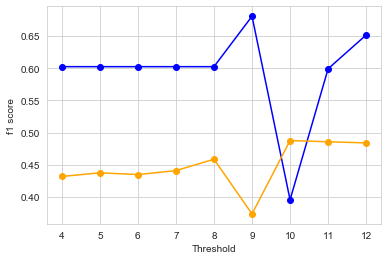

In [79]:
vals = np.arange(4,13)
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = preprocessing(x, True)
    rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200)
    score = f1_score(test_target, rdf.predict(test), average="macro")
    score_cv = cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_rdf.pdf")

We choose 8 because it is one of the best accuracy for trainset and we are not overfitting. What is more, we want to maintain the more data we can.

Now we choose the right criterion between Gini and entropy

gini
entropy


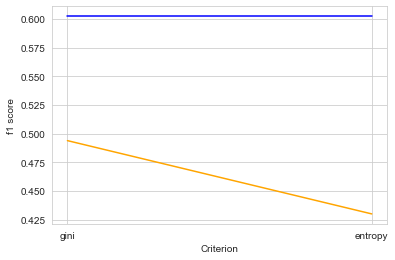

In [80]:
prepro_rdf = preprocessing(8, True)

vals      = ["gini", "entropy"]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = prepro_rdf
    rdf = create_rnd_forest(train, train_target, criterion=x, n_estimators=200)
    score = f1_score(test_target, rdf.predict(test), average="macro")
    score_cv = cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Criterion")
plt.ylabel("f1 score")
plt.savefig("./criterion_rdf.pdf")

Gini is better

Now we optimize the minimum number of samples on a leaf (0.01 is a fraction)

0.001
0.0025118864315095794
0.00630957344480193
0.01584893192461114
0.039810717055349734
0.1
1
2
3
4
5


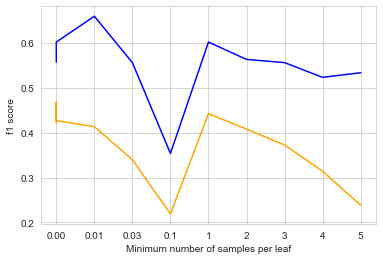

In [87]:
# min_samples_leaf
vals      = list(np.logspace(-3,-1,6)) + [1,2,3,4,5]
vals_disp = [str(x)[:4] for x in vals]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = prepro_rdf
    rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200, min_samples_leaf=x)
    score = f1_score(test_target, rdf.predict(test), average="macro")
    score_cv = cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals_disp, scores, color="blue")
plt.plot(vals_disp, scores_cv, color="orange")
plt.xlabel("Minimum number of samples per leaf")
plt.ylabel("f1 score")
plt.savefig("./min_samples_leaf_rdf.pdf")

The best choice is 1, to have the best accuracy on train set

Now we optimize the complexity parameter used for Minimal Cost-Complexity Pruning

1e-05
3.5938136638046256e-05
0.0001291549665014884
0.0004641588833612782
0.0016681005372000592
0.005994842503189409
0.021544346900318846
0.07742636826811278
0.2782559402207126
1.0


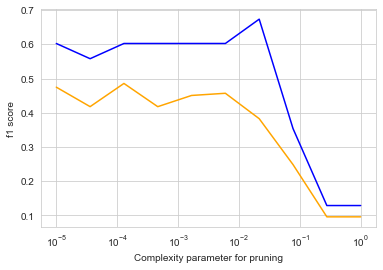

In [89]:
# ccp_alpha 
vals      = np.logspace(-5,0,10)
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = prepro_rdf
    rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200, min_samples_leaf=1, ccp_alpha=x)
    score = f1_score(test_target, rdf.predict(test), average="macro")
    score_cv = cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")
plt.xlabel("Complexity parameter for pruning")
plt.ylabel("f1 score")
plt.savefig("./ccp_alpha_rdf.pdf")

We take cpp_alpha = 0.001 because it's the optimum for the trainset and it is relatively stable

Finally we optimize the mimum samples to split a node

0.01
0.04
0.07
0.1
0.15
0.2
0.3
0.5


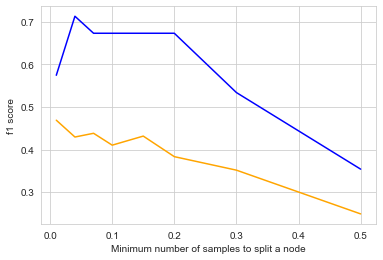

In [91]:
# min_samples_split
vals      = [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = prepro_rdf
    rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200, min_samples_leaf=1, ccp_alpha=1.3e-4, min_samples_split=x)
    score = f1_score(test_target, rdf.predict(test), average="macro")
    score_cv = cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Minimum number of samples to split a node")
plt.ylabel("f1 score")
plt.savefig("./min_samples_split_rdf.pdf")

0.04 seems to be the best choice.

Now we create the random forest that we got manually and we evaluate it :

In [92]:
train, train_target, test, test_target = prepro_rdf
best_rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200, min_samples_leaf=1, ccp_alpha=1.3e-4, min_samples_split=0.04)
new_score = f1_score(train_target, rdf.predict(train), average="macro")
metrics_rdf = evaluate_algo(best_rdf, test, test_target, train, train_target)

RandomForestClassifier(ccp_alpha=0.00013, min_samples_split=0.04,
                       n_estimators=200)
cross validation accuracy train : 0.5952380952380952
accuracy test : 0.8571428571428571
cross validation balanced_accuracy train : 0.4852693602693603
balanced_accuracy test : 0.7133333333333333
cross validation f1_macro train : 0.4330834803057025
f1_macro test : 0.6023391812865496
cross validation precision_macro train : 0.4466042399865929
precision_macro test : 0.611111111111111
cross validation recall_macro train : 0.4713804713804713
recall_macro test : 0.5944444444444444


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T
test : 
[[2 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 2 0 0 0]
 [1 0 0 9 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 5]]
train : 
[[10  0  0  0  0  0]
 [ 0  9  0  1  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0 11]]


So finally we have a random forest which is really underfitting

# Naive Bayes

Test of different preprocessing methods with the optimal parameters found with grid search

5
Fitting 3 folds for each of 6 candidates, totalling 18 fits
6
Fitting 3 folds for each of 6 candidates, totalling 18 fits
7
Fitting 3 folds for each of 6 candidates, totalling 18 fits
8
Fitting 3 folds for each of 6 candidates, totalling 18 fits
9
Fitting 3 folds for each of 6 candidates, totalling 18 fits


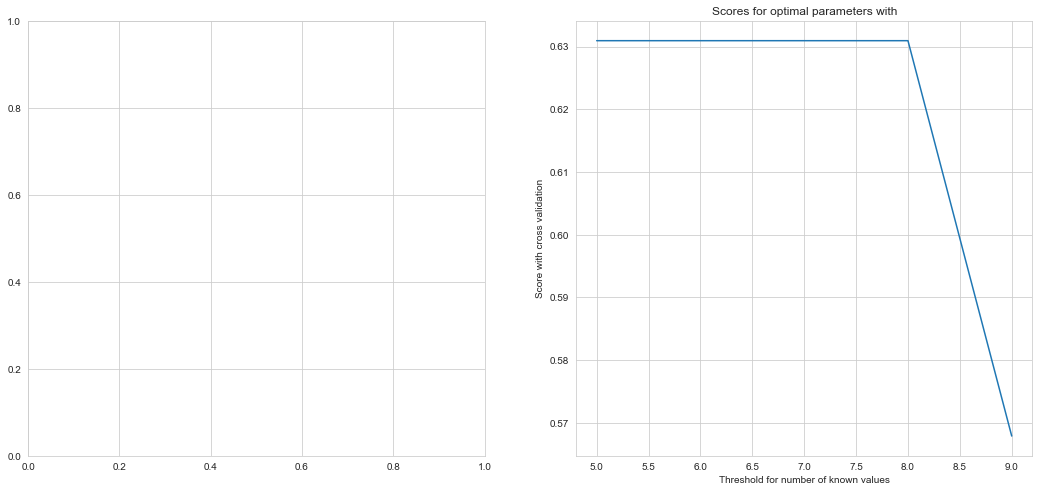

In [157]:
# test of different preprocessing methods with the optimal parameters 

import warnings
warnings.filterwarnings('ignore')

param_grid = {'alpha': [1e-2, 1e-1, 0.5, 1, 10, 100]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True] :
    thresholds = np.arange(5,10)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        NB = []
        PREPROS = []
        n = 5
        
        if (imputation) :
            n=1 
            
        for i in range(n) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            NB.append( create_nb(train, train_target, grid = param_grid) )
            score += NB[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,NB,PREPROS))
        scores.append(score/n)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_nb" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We can see that the relevant imputation is the random imputation, and the optimal threshold is 8.

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [158]:
prepro_text = ""
best_nb = None
datasets = []
score = 0
for (text, NB, PREPROS) in L :
    new_score = 0
    for i in range(len(PREPROS)) :
        prepro = PREPROS[i]
        nb = NB[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += nb.best_score_
    new_score /= 5
    if new_score > score :
        score = new_score
        prepro_text = text
        best_nb = NB
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_nb)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_nb = best_nb[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
nb_grid = create_nb(train, train_target, **best_nb.best_params_)
metrics_nb = evaluate_algo(nb_grid, test, test_target, train, train_target)

imputation: True, threshold = 5
{'alpha': 0.5}


MultinomialNB(alpha=0.5)
cross validation accuracy train : 0.6309523809523809
accuracy test : 0.8571428571428571
cross validation balanced_accuracy train : 0.513047138047138
balanced_accuracy test : 0.7133333333333333
cross validation f1_macro train : 0.5000875444112158
f1_macro test : 0.6637593984962405
cross validation precision_macro train : 0.5339387464387464
precision_macro test : 0.6333333333333333
cross validation recall_macro train : 0.513047138047138
recall_macro test : 0.7133333333333333


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T
test : 
[[2 0 1 0 0]
 [1 0 0 0 0]
 [0 0 2 0 0]
 [1 0 0 9 0]
 [0 0 0 0 5]]
train : 
[[ 7  1  0  2  0  0]
 [ 0  7  1  2  0  0]
 [ 1  0  7  0  0  0]
 [ 1  0  0 32  0  1]
 [ 0  3  0  2  4  2]
 [ 0  0  0  0  0 11]]


We can see that, even if we don't have any overfitting, the algorithm has not a very great accuracy. Here the problem is once again the precision. We use the test set to compare and be aware if we are overfitting too much. 

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

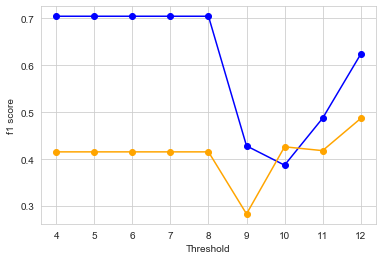

In [97]:
# threshold for preprocessing
vals = np.arange(4,13)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(x, True)
    nb = create_nb(train, train_target)
    score = f1_score(test_target, nb.predict(test), average="macro")
    score_cv = cross_val_score(nb, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_nb.pdf")

We choose 8 because we want have the more data we can and the f1 score does not decrease a lot.

Now we optimize the Laplace smoothing parameter

0.01
0.012663801734674034
0.0160371874375133
0.020309176209047358
0.025719138090593445
0.03257020655659783
0.04124626382901352
0.052233450742668434
0.06614740641230149
0.08376776400682916
0.10608183551394483
0.13433993325989002
0.17012542798525893
0.21544346900318834
0.2728333376486768
0.34551072945922184
0.43754793750741844
0.5541020330009492
0.7017038286703826
0.8886238162743403
1.1253355826007645
1.4251026703029979
1.8047217668271702
2.2854638641349907
2.8942661247167516
3.665241237079626
4.6415888336127775
5.878016072274912
7.443803013251689
9.426684551178854
11.937766417144358
15.117750706156615
19.144819761699576
24.244620170823282
30.702906297578497
38.88155180308085
49.238826317067364
62.355073412739124
78.96522868499724
100.0


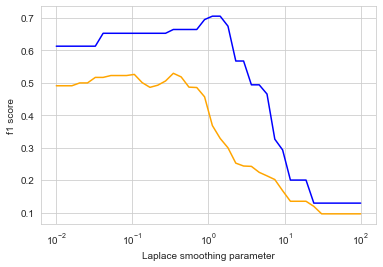

In [159]:
prepro_nb = preprocessing(8, True) 

vals      = np.logspace(-2, 2, 40)
scores    = []
scores_cv = []
for x in vals:
    print(x)
    train, train_target, test, test_target = prepro_nb
    nb = create_nb(train, train_target, alpha=x)
    score = f1_score(test_target, nb.predict(test), average="macro")
    score_cv = cross_val_score(nb, train, train_target,scoring="f1_macro", cv=3).mean()
    scores.append(score)
    scores_cv.append(score_cv)
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")
plt.xlabel("Laplace smoothing parameter")
plt.ylabel("f1 score")
plt.savefig("./laplace_nb.pdf")

0.55 is the best choice (best accuracy for train set).

Now we create the multinomial naive Bayes that we got manually and we evaluate it :

In [160]:
train, train_target, test, test_target = prepro_nb
best_nb = create_nb(train, train_target, alpha=0.55)
metrics_nb = evaluate_algo(best_nb, test, test_target, train, train_target)

MultinomialNB(alpha=0.55)
cross validation accuracy train : 0.630952380952381
accuracy test : 0.8571428571428571
cross validation balanced_accuracy train : 0.5042087542087542
balanced_accuracy test : 0.7133333333333333
cross validation f1_macro train : 0.486180075068964
f1_macro test : 0.6637593984962405
cross validation precision_macro train : 0.531598494098494
precision_macro test : 0.6333333333333333
cross validation recall_macro train : 0.5042087542087542
recall_macro test : 0.7133333333333333


Confusion matrix with the types : WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T
test : 
[[2 0 1 0 0]
 [1 0 0 0 0]
 [0 0 2 0 0]
 [1 0 0 9 0]
 [0 0 0 0 5]]
train : 
[[ 7  0  0  3  0  0]
 [ 0  7  1  2  0  0]
 [ 1  0  7  0  0  0]
 [ 1  0  0 32  0  1]
 [ 0  3  0  2  4  2]
 [ 0  0  0  0  0 11]]


So finally we have a naive Bayes which is not as performant as random forest but which has no over or underfitting. Here also we have a problem of precision. With more samples it would have been better to create a third set which is totally independant and test it again on this validation set.